In [1]:
import sys
sys.path.append('../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300_Siamese import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

# %matplotlib inline

# Set a few configuration parameters.
img_height = 300
img_width = 300
classes = ['background',
           'person', 'rider', 'car', 'truck',
           'bus', 'train', 'motorcycle', 'bicycle']
n_classes = len(classes) - 1
# model_mode indicates the way the pretrained model was created.
# In training model, Model_Build should == 'Load_Model'. decode_detections will be called in the Evaluator.
# However, decode_detections is run on CPU and is very slow.
# In inference model, Model_Build should == 'New_Model_Load_Weights'.
# DecodeDetections will be called when build the model. DecodeDetections is writen in tensorflow and is run GPU.
# It seems that the result under inference model is slightly better than that under training model.
# Maybe DecodeDetections and decode_detections are not exactly the same.
model_mode = 'inference'  # 'training'#
evaluate_mode =  'MAP'  # 'Visualize_detection'  # 
if model_mode == 'inference':
    Model_Build = 'New_Model_Load_Weights'
elif model_mode == 'training':
    Model_Build = 'Load_Model'
else:
    raise ValueError('Undefined model_mode. model_mode should be inference or training')

model_path = '../trained_weights/ssd_augm_alpha_distance_0_1/epoch-07_loss-5.8596_val_loss-8.9792.h5'
# model_path = '../trained_weights/VGG_ssd300_Siamese_Cityscapes_augm_resize/epoch-02_loss-5.5850_val_loss-9.5731.h5'
# model_path = '../../ssd_GAN/trained_weights/VGG_ssd300_Cityscapes/epoch-40_loss-4.6702_val_loss-6.2995.h5'
# model_path = '../../ssd_GAN/trained_weights/VGG_ssd300_SGD_Cityscapes/epoch-34_loss-5.6683_val_loss-8.6284.h5'

if evaluate_mode == 'Visualize_detection':
    confidence_thresh = 0.01
elif evaluate_mode == 'MAP':
    confidence_thresh = 0.01
else:
    raise ValueError('Undefined evaluate_mode.')

batch_size = 16
alpha_distance = 0.01
Build_trainset_for_val = False #True

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if Model_Build == 'New_Model_Load_Weights':
    # 1: Build the Keras model

    K.clear_session()  # Clear previous models from memory.

    # import tensorflow as tf
    # from keras.backend.tensorflow_backend import set_session
    #
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    # config.log_device_placement = True  # to log device placement (on which device the operation ran)
    # # (nothing gets printed in Jupyter, only if you run it standalone)
    # sess = tf.Session(config=config)
    # set_session(sess)  # set this TensorFlow session as the default session for Keras

    # model.output = `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    # In inference mode, the predicted locations have been converted to absolute coordinates.
    # In addition, we have performed confidence thresholding, per-class non-maximum suppression, and top-k filtering.
    model = ssd_300(image_size=(img_height, img_width, 3),
                    n_classes=n_classes,
                    mode=model_mode,
                    l2_regularization=0.0005,
                    scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],
                    aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                             [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                                             [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                                             [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                                             [1.0, 2.0, 0.5],
                                             [1.0, 2.0, 0.5]],
                    two_boxes_for_ar1=True,
                    steps=[8, 16, 32, 64, 100, 300],
                    offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                    clip_boxes=False,
                    variances=[0.1, 0.1, 0.2, 0.2],
                    normalize_coords=True,
                    subtract_mean=[123, 117, 104],
                    swap_channels=[2, 1, 0],
                    confidence_thresh=confidence_thresh,
                    iou_threshold=0.45,
                    top_k=200,
                    nms_max_output_size=400)

    # 2: Load the trained weights into the model
    model.load_weights(model_path, by_name=True)

    # 3: Compile the model so that Keras won't complain the next time you load it.

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0, alpha_distance=alpha_distance)

    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

elif Model_Build == 'Load_Model':
    # We need to create an SSDLoss object in order to pass that to the model loader.
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0, alpha_distance=alpha_distance)

    K.clear_session()  # Clear previous models from memory.

    # import tensorflow as tf
    # from keras.backend.tensorflow_backend import set_session
    #
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    # config.log_device_placement = True  # to log device placement (on which device the operation ran)
    # # (nothing gets printed in Jupyter, only if you run it standalone)
    # sess = tf.Session(config=config)
    # set_session(sess)  # set this TensorFlow session as the default session for Keras

    model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                   'L2Normalization': L2Normalization,
                                                   'DecodeDetections': DecodeDetections,
                                                   'compute_loss': ssd_loss.compute_loss,
                                                   'compute_distance_loss': ssd_loss.compute_distance_loss})

else:
    raise ValueError('Undefined Model_Build. Model_Build should be New_Model_Load_Weights or Load_Model')

In [3]:
## Creat trainset for validation, foggy image is not used in the validation
if Build_trainset_for_val:
    train_dataset = DataGenerator(dataset='val', load_images_into_memory=False, hdf5_dataset_path=None)

    # 2: Parse the image and label lists for the training and validation datasets. This can take a while.

    # TODO: Set the paths to the datasets here.

    # Introduction of PascalVOC: https://arleyzhang.github.io/articles/1dc20586/
    # The directories that contain the images.
    Cityscapes_images_dir = '../../datasets/Cityscapes/JPEGImages'

    # The directories that contain the annotations.
    Cityscapes_annotation_dir = '../../datasets/Cityscapes/Annotations'

    # The paths to the image sets.
    Cityscapes_train_source_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_source.txt'

    # images_dirs, image_set_filenames, and annotations_dirs should have the same length
    train_dataset.parse_xml(images_dirs=[Cityscapes_images_dir],
                            image_set_filenames=[Cityscapes_train_source_image_set_filename],
                            annotations_dirs=[Cityscapes_annotation_dir],
                            classes=classes,
                            include_classes='all',
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    # Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
    # speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
    # option in the constructor, because in that cas the images are in memory already anyway. If you don't
    # want to create HDF5 datasets, comment out the subsequent two function calls.

    # After create these h5 files, if you have resized the input image, you need to reload these files. Otherwise,
    # the images and the labels will not change.

    resize_image_to = (300, 600)
    train_dataset.create_hdf5_dataset(file_path='dataset_cityscapes_train_for_val_without_foggy_image.h5',
                                      resize=resize_image_to,
                                      variable_image_size=True,
                                      verbose=True)

    train_dataset = DataGenerator(dataset='val', 
                                  load_images_into_memory=False,
                                  hdf5_dataset_path='dataset_cityscapes_train_for_val_without_foggy_image.h5',
                                  filenames=Cityscapes_train_source_image_set_filename,
                                  filenames_type='text',
                                  images_dir=Cityscapes_images_dir)


In [4]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Load dataset from the created h5 file.

# The directories that contain the images.
Cityscapes_images_dir = '../../datasets/Cityscapes/JPEGImages'

# The paths to the image sets.
Cityscapes_train_source_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_source.txt'
Cityscapes_test_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/test.txt'

train_dataset = DataGenerator(dataset='val',
                              load_images_into_memory=False,
                              hdf5_dataset_path='dataset_cityscapes_train_for_val_without_foggy_image.h5',
                              filenames=Cityscapes_train_source_image_set_filename,
                              filenames_type='text',
                              images_dir=Cityscapes_images_dir)

val_dataset = DataGenerator(dataset='val',
                            load_images_into_memory=False,
                            hdf5_dataset_path='dataset_cityscapes_test.h5',
                            filenames=Cityscapes_test_target_image_set_filename,
                            filenames_type='text',
                            images_dir=Cityscapes_images_dir)

Loading evaluation-neutrality annotations: 100%|██████████| 493/493 [00:00<00:00, 8197.94it/s]


Number of images in the evaluation dataset: 2966

Matching predictions to ground truth, class 8/8.: 100%|██████████| 21920/21920 [00:01<00:00, 17226.17it/s]
Computing precisions and recalls, class 1/8
Computing precisions and recalls, class 2/8
Computing precisions and recalls, class 3/8
Computing precisions and recalls, class 4/8
Computing precisions and recalls, class 5/8
Computing precisions and recalls, class 6/8
Computing precisions and recalls, class 7/8
Computing precisions and recalls, class 8/8
Computing average precision, class 1/8
Computing average precision, class 2/8
Computing average precision, class 3/8
Computing average precision, class 4/8
Computing average precision, class 5/8
Computing average precision, class 6/8
Computing average precision, class 7/8
Computing average precision, class 8/8
person        AP    0.087
rider         AP    0.116
car           AP    0.391
truck         AP    0.101
bus           AP    0.145
train         AP    0.091
motorcycle    AP    0.0

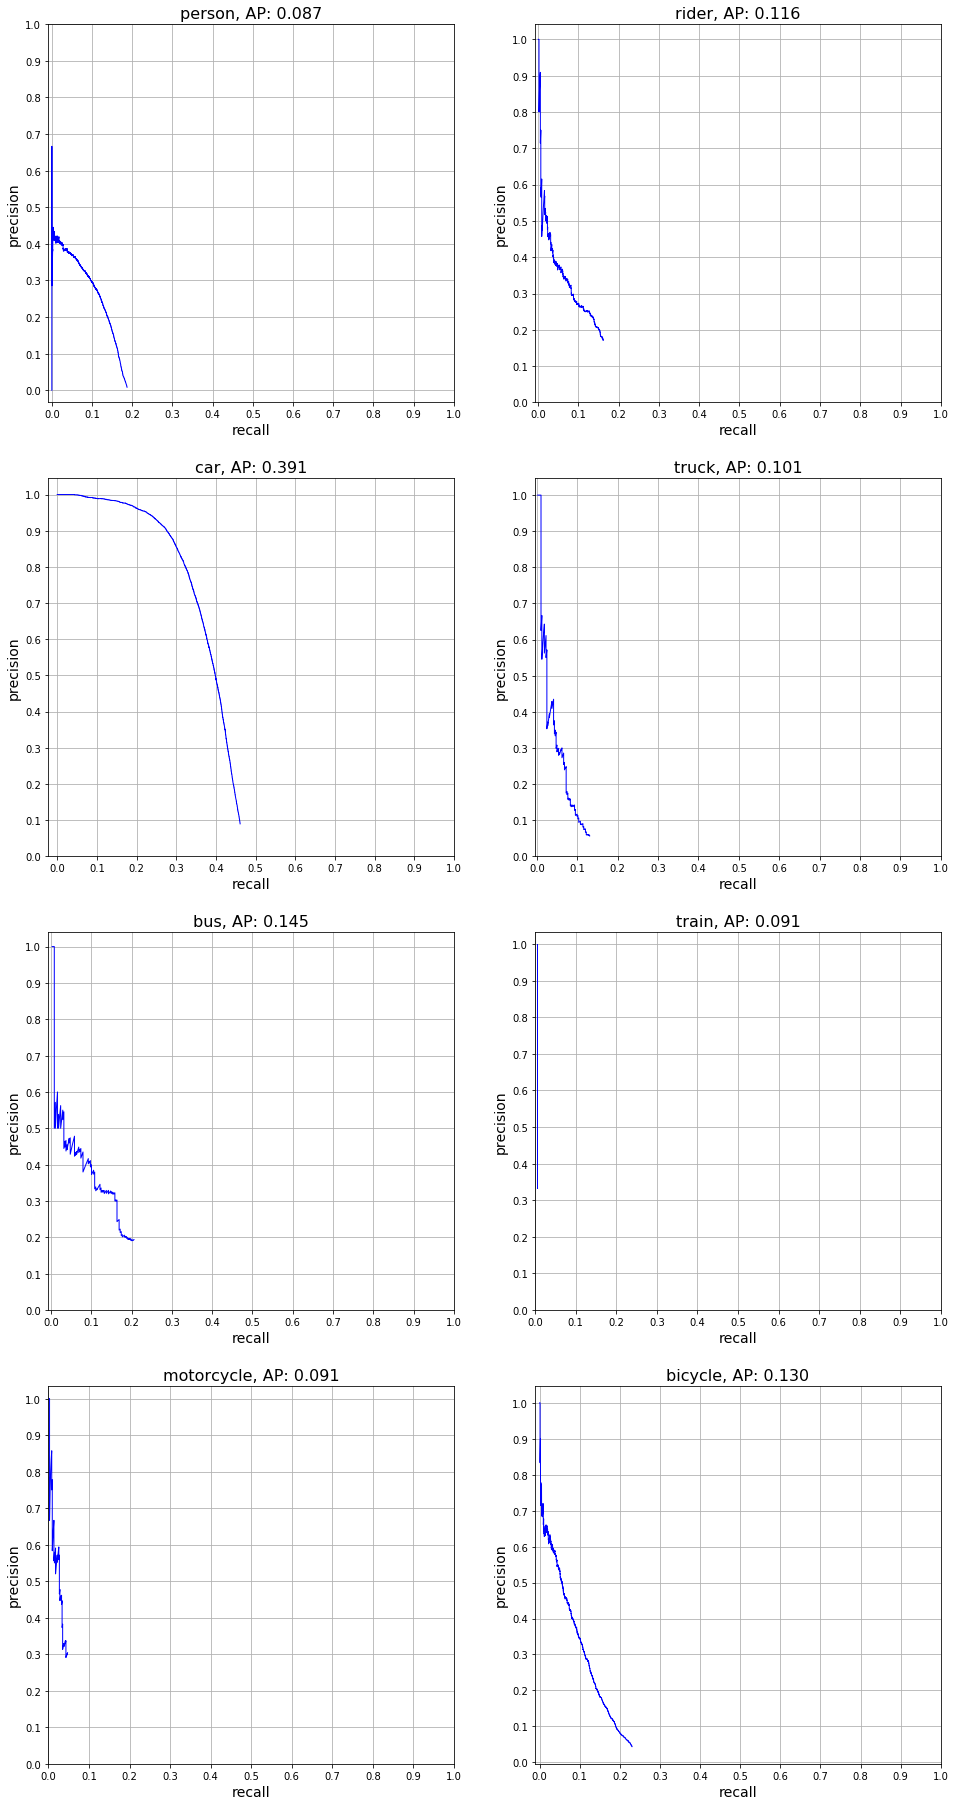

In [6]:
if evaluate_mode == 'Visualize_detection':
    # Make predictions:
    # 1: Set the generator for the predictions.

    # For the test generator:
    from data_generator.object_detection_2d_geometric_ops import Resize
    from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
    from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

    # First convert the input image to 3 channels and size img_height X img_width
    # Also, convert the groundtruth bounding box
    # Remember, if you want to visualize the predicted box on the original image,
    # you need to apply the corresponding reverse transformation.
    convert_to_3_channels = ConvertTo3Channels()
    resize = Resize(height=img_height, width=img_width)

    test_generator = val_dataset.generate(batch_size=batch_size,
                                            shuffle=False,
                                            transformations=[convert_to_3_channels,
                                                             resize],
                                            label_encoder=None,
                                            returns={'processed_images',
                                                     'filenames',
                                                     'inverse_transform',
                                                     'original_images',
                                                     'original_labels'},
                                            keep_images_without_gt=False)

    # test_dataset_size = test_generator.get_dataset_size()
    # print("Number of images in the test dataset:\t{:>6}".format(test_dataset_size))

    # 2: Generate samples.
    # The order of these returned items are not determined by the keys in returns in the previous cell,
    # but by the order defined in DataGenerator.generate()
    batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(test_generator)

    i = 1 # Which batch item to look at
    print("Image:", batch_filenames[i])
    print()
    print("Ground truth boxes:\n")
    print(np.array(batch_original_labels[i]))

    # 3: Make predictions.
    y_pred = model.predict(batch_images)

    # 4: Convert the predictions for the original image.

    y_pred_decoded_inv = apply_inverse_transforms(y_pred, batch_inverse_transforms)

    np.set_printoptions(precision=2, suppress=True, linewidth=90)
    print("Predicted boxes:\n")
    print('   class   conf xmin   ymin   xmax   ymax')
    print(y_pred_decoded_inv[i])

    # 5: Draw the predicted boxes onto the image

    # Set the colors for the bounding boxes
    colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()

    plt.figure(figsize=(20,12))
    plt.imshow(batch_original_images[i])

    current_axis = plt.gca()

#     for box in batch_original_labels[i]:
#         xmin = box[1]
#         ymin = box[2]
#         xmax = box[3]
#         ymax = box[4]
#         label = '{}'.format(classes[int(box[0])])
#         current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
#         current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha': 1.0})

    good_prediction = [val for val in y_pred_decoded_inv[i] if val[1] > 0.35 ]  # confidence_thresh

    for box in good_prediction:
        xmin = box[2]
        ymin = box[3]
        xmax = box[4]
        ymax = box[5]
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': color, 'alpha':1.0})
    # for box in y_pred_decoded_inv[i]:
    #     xmin = box[2]
    #     ymin = box[3]
    #     xmax = box[4]
    #     ymax = box[5]
    #     color = colors[int(box[0])]
    #     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    #     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
    #     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

elif evaluate_mode == 'MAP':
    evaluator = Evaluator(model=model,
                          n_classes=n_classes,
                          data_generator=train_dataset,  
                          model_mode=model_mode)

    results = evaluator(img_height=img_height,
                        img_width=img_width,
                        batch_size=batch_size,
                        data_generator_mode='resize',
                        round_confidences=False,
                        matching_iou_threshold=0.5,
                        border_pixels='include',
                        sorting_algorithm='quicksort',
                        average_precision_mode='sample',
                        num_recall_points=11,
                        ignore_neutral_boxes=True,
                        return_precisions=True,
                        return_recalls=True,
                        return_average_precisions=True,
                        verbose=True)

    mean_average_precision, average_precisions, precisions, recalls = results

    for i in range(1, len(average_precisions)):
        print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
    print()
    print("{:<14}{:<6}{}".format('', 'mAP', round(mean_average_precision, 3)))

    m = max((n_classes + 1) // 2, 2)
    n = 2

    fig, cells = plt.subplots(m, n, figsize=(n*8, m*8))
    for i in range(m):
        for j in range(n):
            if n*i+j+1 > n_classes: break
            cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
            cells[i, j].set_xlabel('recall', fontsize=14)
            cells[i, j].set_ylabel('precision', fontsize=14)
            cells[i, j].grid(True)
            cells[i, j].set_xticks(np.linspace(0, 1, 11))
            cells[i, j].set_yticks(np.linspace(0, 1, 11))
            cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

else:
    raise ValueError('Undefined evaluate_mode.')